In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from hawkes import hawkes, hawkes_calculate, sampleHawkes, plotHawkes, iterative_sampling
sys.path.append(os.path.abspath('../'))
from sampling_utils import thinning_T, return_samples
from counterfactual_tpp import sample_counterfactual, check_monotonicity

# Sampling From Lambda_max

**Algorithm 1 and 2**

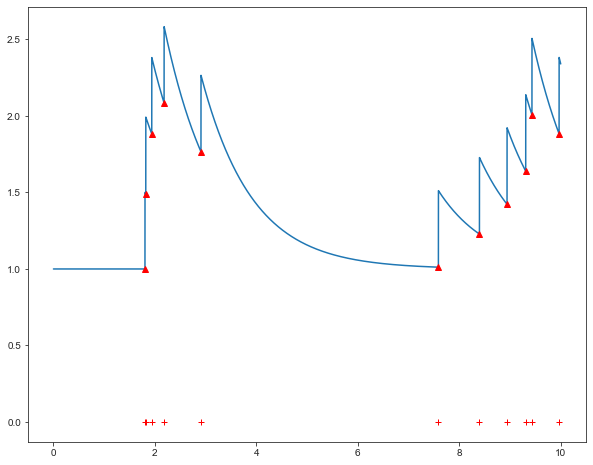

In [2]:

mu0 = 1
alpha = 0.5
w = 1
lambda_max = 4
T = 10
maxNev = 50
def constant1(x): return mu0
initial_sample, indicators = thinning_T(0, constant1, lambda_max, maxNev, T)
events = {initial_sample[i]: indicators[i] for i in range(len(initial_sample))}
all_events = {}
all_events[mu0] = events
iterative_sampling(all_events, events, mu0, alpha, w, lambda_max, maxNev, T)
sampled_events = list(all_events.keys())[1:]
sampled_events.sort()
sampled_events = np.array(sampled_events)
sampled_lambdas = hawkes(sampled_events, mu0, alpha, w)
plt.figure(figsize=(10, 8))
tvec, l_t = plotHawkes(sampled_events, mu0, alpha, w, T, 10000.0, label= 'intensity')
plt.plot(sampled_events, sampled_lambdas, 'r^')
plt.show() 

In [3]:
all_samples = []
for events in list(all_events.values()):
    all_samples.extend(list(events.keys()))
all_samples.sort()
all_samples = np.array(all_samples)
all_lambdas = [hawkes_calculate(x, sampled_events, mu0, alpha, w) for x in all_samples]
all_lambdas = np.array(all_lambdas)

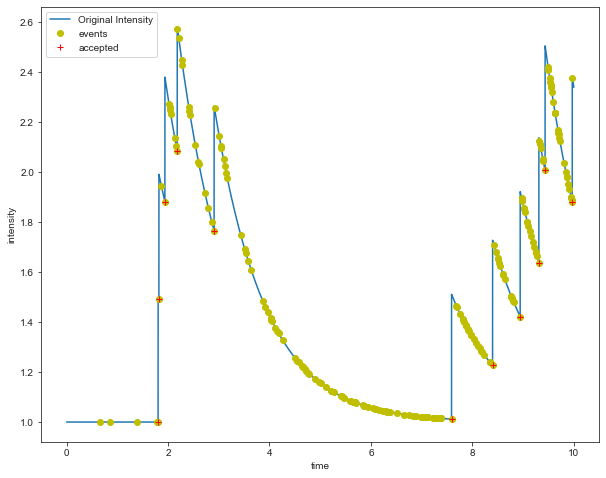

In [4]:
plt.figure(figsize=(10, 8))
plt.plot(tvec, l_t, label = 'Original Intensity')
plt.plot(all_samples, all_lambdas, 'oy', label = 'events')
plt.plot(sampled_events,sampled_lambdas, 'r+', label = 'accepted')
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()

**Algorithm 3**

In [5]:
new_mu0 = 1
new_alpha = 0.2
def constant2(x): return new_mu0
count = 0
counterfactuals = {}
for t_i, events in all_events.items():
    sample = list(events.keys())
    if count == 0:
        lambdas = [constant1(s) for s in sample]
        counterfactuals_events, counterfactual_indicators = sample_counterfactual(sample, lambdas, lambda_max, list(events.values()), constant2)
    else:
        def f(t): return alpha * np.exp(-w * (t - t_i))
        def g(t): return new_alpha * np.exp(-w * (t - t_i))
        lambdas = [f(s) for s in sample]
        counterfactuals_events, counterfactual_indicators = sample_counterfactual(sample, lambdas, lambda_max, list(events.values()), g)
    count+=1
    counterfactuals.update({sample[s]: counterfactual_indicators[s] for s in range(len(sample))})

In [6]:
rej_acc_events = {}
for events in list(all_events.values()):
    for t_i in list(events.keys()):
        if events[t_i] == False and counterfactuals[t_i] == True:
            rej_acc_events[t_i] = True

In [7]:
new_events = {}
iterative_sampling(new_events, rej_acc_events, new_mu0, new_alpha, w, lambda_max, maxNev, T)
# These are the additional counterfactuals sampled from the new intensity.
sampled_counterfactuals = list(new_events.keys())
sampled_counterfactuals.sort()

In [8]:
# Combine all counterfactuals
real_counterfactuals = [k for k, v in counterfactuals.items() if v == True]
real_counterfactuals.extend(sampled_counterfactuals)
real_counterfactuals.sort()
print(len(sampled_events))
print(len(real_counterfactuals))


11
8


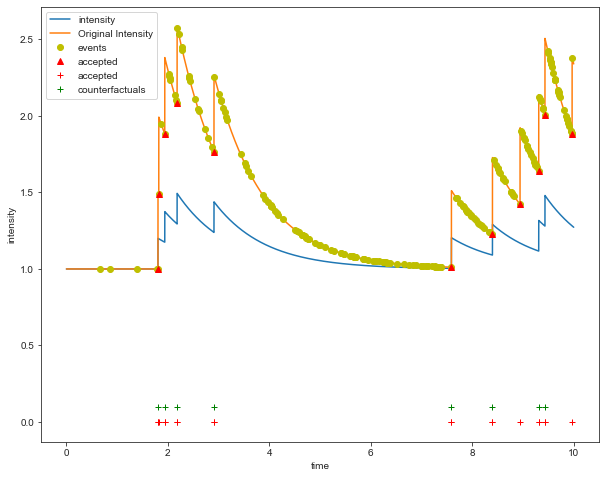

In [9]:
plt.figure(figsize=(10, 8))
plotHawkes(np.array(real_counterfactuals), new_mu0, new_alpha, w, T, 10000.0, label= 'intensity')
plt.plot(tvec, l_t, label = 'Original Intensity')
plt.plot(all_samples, all_lambdas, 'oy', label = 'events')
plt.plot(sampled_events,sampled_lambdas, 'r^', label = 'accepted')
plt.plot(sampled_events,np.zeros(len(sampled_events)), 'r+', label = 'accepted')
plt.plot(real_counterfactuals, [0.1] * len(real_counterfactuals), 'g+', label = 'counterfactuals')
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend() 

# Real-World Scenario

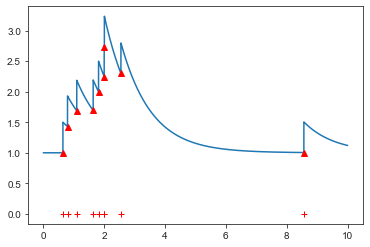

In [105]:
# First, we sample from the hawkes process using the Ogata's algorithm (or any other sampling method), but only store the accepted events.
mu0 = 1
alpha = 0.5
w = 1
lambda_max = 4
T = 10
maxNev = 25
tev, tend, lambdas_original = sampleHawkes(mu0, alpha, w, T, maxNev)
tvec, l_t = plotHawkes(tev, mu0, alpha, w, T, 10000.0, label = 'Original Intensity')
plt.plot(tev, lambdas_original, 'r^', label = 'samples')


In [106]:
# this list stores functions corresponding to each exponential.
exponentials = []
all_events = {}
exponentials.append(lambda t: mu0)
all_events[mu0] = {}
for i in range(len(tev)):
    exponentials.append(lambda t: alpha * np.exp(-w * (t - tev[i])))
    all_events[tev[i]] = {}

In [107]:
# we should assign each accepted event to some exponential. (IMPORTANT)
for i in range(len(tev)):
    if i == 0:
        all_events[mu0][tev[i]] = True
    else:
        probabilities = [exponentials[j](tev[i]) for j in range(0, i + 1)]
        probabilities = [float(i)/sum(probabilities) for i in probabilities]
        a = np.random.choice(i + 1, 1, p = probabilities)
        if a == 0:
            all_events[mu0][tev[i]] = True
        else:
            all_events[tev[a[0] - 1]][tev[i]] = True

In [109]:
# using the superposition to calculate the difference between lambda_max and the exponentials, and sample from it.
differences = []
differences.append(lambda t: lambda_max - mu0)
for k in range(len(tev)):
    f = lambda t: lambda_max - alpha * np.exp(-w * (t - tev[k]))
    differences.append(f)

for i in range(len(differences)):
    if i == 0:
        rejceted, indicators = thinning_T(0, differences[i], lambda_max, maxNev, T)
    else:
        rejceted, indicators = thinning_T(tev[i - 1], differences[i], lambda_max, maxNev, T)
    
    rejceted = {rejceted[j]: False for j in range(len(rejceted)) if indicators[j] == True}
    if i == 0:
        all_events[mu0].update(rejceted)
        all_events[mu0] = {k:v for k,v in sorted(all_events[mu0].items())}
    else:
        all_events[tev[i - 1]].update(rejceted)
        all_events[tev[i - 1]] = {k:v for k,v in sorted(all_events[tev[i - 1]].items())}


In [110]:
all_samples = []
for events in list(all_events.values()):
    all_samples.extend(list(events.keys()))
all_samples.sort()
all_samples = np.array(all_samples)
all_lambdas = [hawkes_calculate(x, tev, mu0, alpha, w) for x in all_samples]
all_lambdas = np.array(all_lambdas)

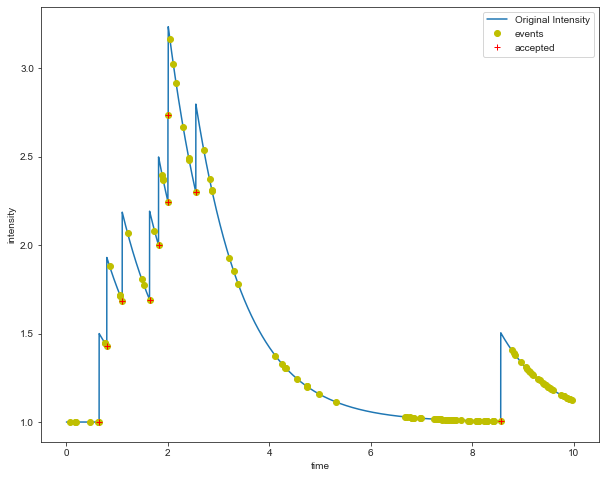

In [111]:
plt.figure(figsize=(10, 8))
plt.plot(tvec, l_t, label = 'Original Intensity')
plt.plot(all_samples, all_lambdas, 'oy', label = 'events')
plt.plot(tev,lambdas_original, 'r+', label = 'accepted')
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()

In [117]:
new_mu0 = 1
new_alpha = 0.2
def constant1(x): return mu0
def constant2(x): return new_mu0
count = 0
counterfactuals = {}
for t_i, events in all_events.items():
    sample = list(events.keys())
    if count == 0:
        lambdas = [constant1(s) for s in sample]
        counterfactuals_events, counterfactual_indicators = sample_counterfactual(sample, lambdas, lambda_max, list(events.values()), constant2)
    else:
        def f(t): return alpha * np.exp(-w * (t - t_i))
        def g(t): return new_alpha * np.exp(-w * (t - t_i))
        lambdas = [f(s) for s in sample]
        counterfactuals_events, counterfactual_indicators = sample_counterfactual(sample, lambdas, lambda_max, list(events.values()), g)
    count+=1
    counterfactuals.update({sample[s]: counterfactual_indicators[s] for s in range(len(sample))})

In [118]:
rej_acc_events = {}
for events in list(all_events.values()):
    for t_i in list(events.keys()):
        if events[t_i] == False and counterfactuals[t_i] == True:
            rej_acc_events[t_i] = True

In [119]:
new_events = {}
iterative_sampling(new_events, rej_acc_events, new_mu0, new_alpha, w, lambda_max, maxNev, T)
# These are the additional counterfactuals sampled from the new intensity.
sampled_counterfactuals = list(new_events.keys())
sampled_counterfactuals.sort()

In [120]:
# Combine all counterfactuals
real_counterfactuals = [k for k, v in counterfactuals.items() if v == True]
real_counterfactuals.extend(sampled_counterfactuals)
real_counterfactuals.sort()
print(len(tev))
print(len(real_counterfactuals))

9
4


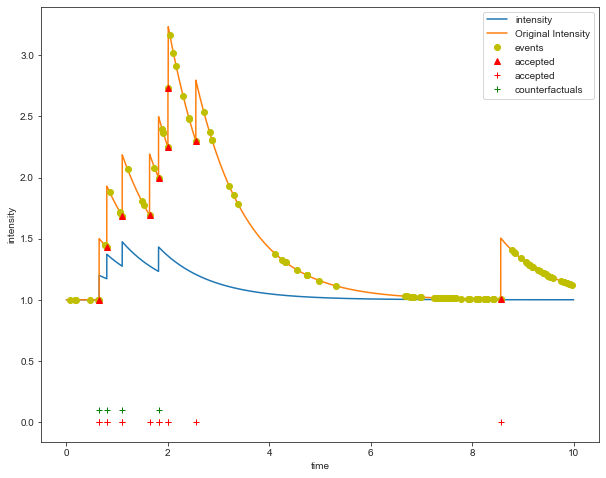

In [121]:
plt.figure(figsize=(10, 8))
plotHawkes(np.array(real_counterfactuals), new_mu0, new_alpha, w, T, 10000.0, label= 'intensity')
plt.plot(tvec, l_t, label = 'Original Intensity')
plt.plot(all_samples, all_lambdas, 'oy', label = 'events')
plt.plot(tev,lambdas_original, 'r^', label = 'accepted')
plt.plot(tev,np.zeros(len(tev)), 'r+', label = 'accepted')
plt.plot(real_counterfactuals, [0.1] * len(real_counterfactuals), 'g+', label = 'counterfactuals')
plt.xlabel('time')
plt.ylabel('intensity')
plt.legend()  